In [ ]:
###  COPY ALL THE CODE INTO A JYPYTER NOTEBOOK  ### 
###  THE JYPYTER NOTEBOOK NEEDS TO BE IN 'tensorflow\models\research\deeplab'  ### 
## https://averdones.github.io/real-time-semantic-image-segmentation-with-deeplab-in-tensorflow/


import collections
import os
import io
import sys
import tarfile
import tempfile
import urllib
import shutil

from IPython import display
from ipywidgets import interact
from ipywidgets import interactive
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2

from tqdm import tqdm
import tensorflow as tf

from google.colab import drive
drive.mount('/content/Google_Drive')

print(tf.__version__)
print("Runtime completed.")

Drive already mounted at /content/Google_Drive; to attempt to forcibly remount, call drive.mount("/content/Google_Drive", force_remount=True).
2.4.1
Runtime completed.


In [ ]:
## Load model in TensorFlow

class DeepLabModel(object):
    """Class to load deeplab model and run inference."""
    
    _FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self._FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
        
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():      
            tf.import_graph_def(graph_def, name='')        

        self.sess = tf.compat.v1.Session(graph=self.graph)
            
    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.
        
        Args:
            image: A PIL.Image object, raw input image.
            
        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        target_size = (2049,1025)
        # resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        # target_size = (int(resize_ratio * width), int(resize_ratio * height))
        # target_size = (width, height)
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]

        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map, -1)  # need an extra dimension for cv.resize
        seg_map = cv2.resize(seg_map, (width,height), interpolation=cv2.INTER_NEAREST)

        return seg_map
print("Class model construted.")

Class model construted.


In [ ]:
# Copyright 2018 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Visualizes the segmentation results via specified color map.

Visualizes the semantic segmentation results by the color map
defined by the different datasets.
"""

def create_label_colormap():
  """Creates a label colormap used in CITYSCAPES segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.asarray([
      [128, 64, 128],
      [244, 35, 232],
      [70, 70, 70],
      [102, 102, 156],
      [190, 153, 153],
      [153, 153, 153],
      [250, 170, 30],
      [220, 220, 0],
      [107, 142, 35],
      [152, 251, 152],
      [70, 130, 180],
      [220, 20, 60],
      [255, 0, 0],
      [0, 0, 142],
      [0, 0, 70],
      [0, 60, 100],
      [0, 80, 100],
      [0, 0, 230],
      [119, 11, 32],
      [0, 0, 0]], dtype=np.uint8)
  return colormap

def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.
    dataset: The colormap used in the dataset.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_label_colormap()
  
  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')
  return colormap[label]

print("Runtime completed.")

Runtime completed.


In [ ]:
# Load the model from local path
content_path = "Google_Drive/MyDrive/"

tarball_path = content_path + "deeplab_cityscapes_xception71_trainfine_2018_09_08.tar.gz"
model_local = DeepLabModel(tarball_path)
print('Local model loaded successfully!\n')


"""
  Download the model online from tensorflow
"""
# MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
MODEL_NAME = 'xception65_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.compat.v1.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

model_online = DeepLabModel(download_path)
print('Online model loaded successfully!')

Local model loaded successfully!

downloading model, this might take a while...
download completed! loading DeepLab model...
Online model loaded successfully!


In [ ]:
# Webcam demo
# cap = cv2.VideoCapture(0)
videopath = content_path + r'Experiment_Material'
outpath = r'cityscapes_seg_results'

def makeNewPath(input_path):
  if os.path.exists(input_path):
    shutil.rmtree(input_path)
  os.mkdir(input_path)

makeNewPath(outpath)
print(outpath, 'created.')

def segmentThem(videopath):
  for f in os.listdir(videopath):
      urban_simulus = f[:-4]
      outdir = outpath + '/' + urban_simulus
      makeNewPath(outdir)
      print(outdir, 'created.')

      videofile = videopath + '/' + f
      cap = cv2.VideoCapture(videofile)

      rval = True
      frame_no = 1
      while rval:
          rval, frame = cap.read()

          if not rval:
              break

          # From cv2 to PIL
          # cv2_im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          # pil_im = Image.fromarray(cv2_im)
          pil_im = Image.fromarray(frame)

          # Run model
          seg_map = model_local.run(pil_im)

          # Adjust color of mask
          seg_image = label_to_color_image(seg_map).astype(np.uint8)

          outfilename = 'frame%06d.png' % frame_no
          frame_no = frame_no + 1
          cv2.imwrite(outdir + '/' + outfilename, seg_image)

          print(urban_simulus, outfilename, 'saved.')

segmentThem(videopath)

流式输出内容被截断，只能显示最后 5000 行内容。
FinancialSt_H frame003595.png saved.
FinancialSt_H frame003596.png saved.
FinancialSt_H frame003597.png saved.
FinancialSt_H frame003598.png saved.
FinancialSt_H frame003599.png saved.
FinancialSt_H frame003600.png saved.
FinancialSt_H frame003601.png saved.
FinancialSt_H frame003602.png saved.
FinancialSt_H frame003603.png saved.
FinancialSt_H frame003604.png saved.
FinancialSt_H frame003605.png saved.
FinancialSt_H frame003606.png saved.
FinancialSt_H frame003607.png saved.
FinancialSt_H frame003608.png saved.
FinancialSt_H frame003609.png saved.
FinancialSt_H frame003610.png saved.
FinancialSt_H frame003611.png saved.
FinancialSt_H frame003612.png saved.
FinancialSt_H frame003613.png saved.
FinancialSt_H frame003614.png saved.
FinancialSt_H frame003615.png saved.
FinancialSt_H frame003616.png saved.
FinancialSt_H frame003617.png saved.
FinancialSt_H frame003618.png saved.
FinancialSt_H frame003619.png saved.
FinancialSt_H frame003620.png saved.
FinancialSt

In [ ]:
!zip -r /content/seg_results_3.zip /content/cityscapes_seg_results/

In [ ]:
% mv seg_results_3.zip Google_Drive/MyDrive/

In [ ]:
#from google.colab import files
#files.download("/content/seg_results_3.zip")

In [ ]:
# Visualization

def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

Please input the image link.http://www.trbimg.com/img-5b88283c/turbine/bs-md-mta-subway-review-20180830
running deeplab on the sample image...


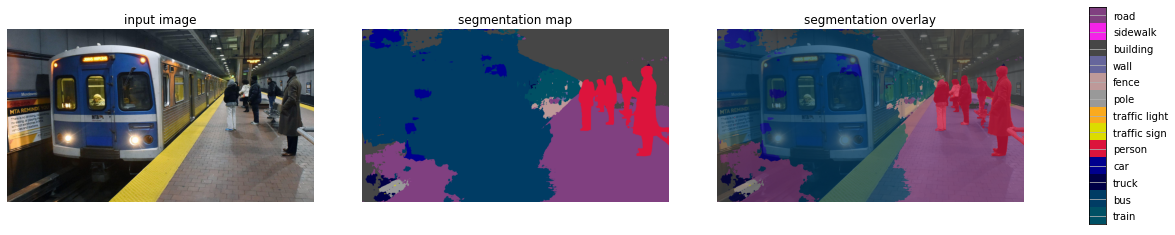

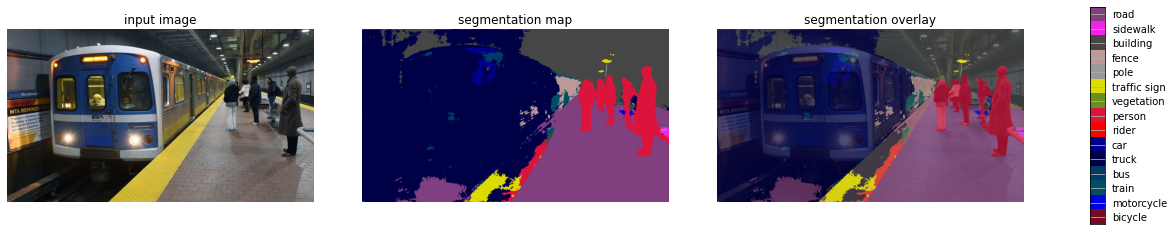

In [ ]:
weblink = input("Please input the image link.")
SAMPLE_IMAGE = urllib.request.urlretrieve(weblink)[0]
print('running deeplab on the sample image...')

def run_visualization(SAMPLE_IMAGE, model):
    """Inferences DeepLab model and visualizes result."""
    original_im = Image.open(SAMPLE_IMAGE)
    seg_map = model.run(original_im)
    vis_segmentation(original_im, seg_map)

run_visualization(SAMPLE_IMAGE, model_local)
run_visualization(SAMPLE_IMAGE, model_online)